In [4]:
import numpy as np
import pandas as pd

import pandas_datareader.data as web
import yfinance as yf
yf.pdr_override()
import datetime

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [5]:
import warnings
warnings.filterwarnings('ignore')

### Loading data

In [39]:
data = pd.read_csv("data.csv")
data['datetime'] = pd.to_datetime(data['datetime'])
data.sort_values(by='datetime', inplace=True)
data.set_index('datetime', inplace=True)

return_period = 102

Y = np.log(data['close_cac']).diff(return_period).shift(-return_period)


X1 = np.log(data['Close_x']).diff(return_period)


X2 = np.log(data['Close_y']).diff(return_period)


X3 = np.log(data['SMA_cac']).diff(return_period)


X4 = np.log(data['EMA_cac']).diff(return_period)


X5 = np.log(data['WMA_cac']).diff(return_period)


X6 = np.log(data['TRIMA_cac']).diff(return_period)


X7 = np.log(data['DEMA_cac']).diff(return_period)

X10 = pd.concat([np.log(data['close_cac']).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X10.columns = ['CAC_DT', 'CAC_3DT', 'CAC_6DT', 'CAC_12DT']

X = pd.concat([X1, X2, X3, X4,X5,X6,X7,X10], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

In [37]:
dataset.head()

,close_cac,Close_x,Close_y,SMA_cac,EMA_cac,WMA_cac,TRIMA_cac,DEMA_cac,CAC_DT,CAC_3DT,CAC_6DT,CAC_12DT
datetime,,,,,,,,,,,,
2015-01-02 14:00:00,0.000704,0.000242,0.000636,0.0,0.0,0.0,-0.000079,0.000043,0.001175,0.000940,-0.001643,-0.007720
2015-01-02 14:25:00,-0.000235,-0.000097,0.000175,0.0,0.0,0.0,-0.000032,0.000160,0.000704,0.000235,-0.001407,-0.005850
2015-01-02 14:50:00,0.003983,0.000242,0.000362,0.0,0.0,0.0,0.000026,0.000310,-0.000235,0.001645,0.000939,-0.000469
2015-01-02 15:15:00,0.002102,-0.002811,-0.001952,0.0,0.0,0.0,0.000102,0.000553,0.003983,0.004452,0.005392,0.007746
2015-01-02 15:40:00,-0.000700,-0.004231,-0.007900,0.0,0.0,0.0,0.000240,0.000995,0.002102,0.005850,0.006085,0.011027


### Splitting data

In [40]:
test_size = 0.2

train_size = int(len(X) * (1-test_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

Y_test.index

DatetimeIndex(['2015-10-10 05:30:00', '2015-10-10 14:00:00',
               '2015-10-10 22:30:00', '2015-10-11 07:00:00',
               '2015-10-11 15:30:00', '2015-10-12 00:00:00',
               '2015-10-12 08:30:00', '2015-10-12 17:00:00',
               '2015-10-13 01:30:00', '2015-10-13 10:00:00',
               ...
               '2015-12-15 02:30:00', '2015-12-15 11:00:00',
               '2015-12-15 19:30:00', '2015-12-16 04:00:00',
               '2015-12-16 12:30:00', '2015-12-16 21:00:00',
               '2015-12-17 05:30:00', '2015-12-17 14:00:00',
               '2015-12-17 22:30:00', '2015-12-18 07:00:00'],
              dtype='datetime64[ns]', name='datetime', length=196, freq=None)

### Preparing data

In [41]:
seq_len = 2 # Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [42]:
X_train_LSTM.shape

(780, 2, 11)

### Creating the models using Keras

In [43]:
# 1 LSTM layer with 50 outputs and 1 Dense layer with 1 output

model1 = Sequential()
model1.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
model1.add(Dense(1))

In [44]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                12400     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12451 (48.64 KB)
Trainable params: 12451 (48.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


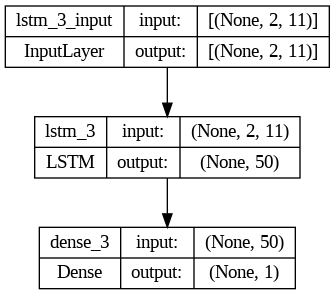

In [45]:
keras.utils.plot_model(model1, show_shapes=True)

In [46]:
# 1 LSTM layer with 1 output

model2 = Sequential()
model2.add(LSTM(1, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))

In [47]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1)                 52        
                                                                 
Total params: 52 (208.00 Byte)
Trainable params: 52 (208.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


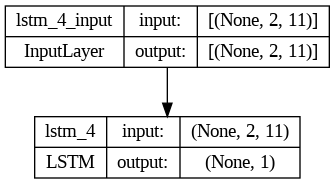

In [48]:
keras.utils.plot_model(model2, show_shapes=True)

In [49]:
# 1 LSTM layer with 50 outputs, 1 Dense layer with 10 outputs, and 1 Dense layer with 1 output

model3 = Sequential()
model3.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
model3.add(Dense(10))
model3.add(Dense(1))

In [50]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                12400     
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 12921 (50.47 KB)
Trainable params: 12921 (50.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


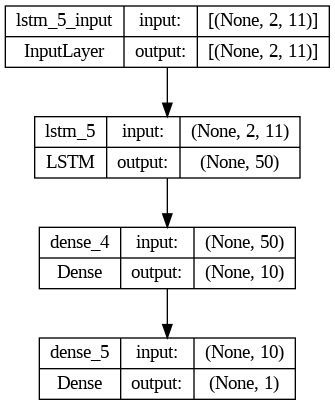

In [51]:
keras.utils.plot_model(model3, show_shapes=True)

### Compiling the model

In [52]:
model1.compile(loss="mse", optimizer="adam")
model2.compile(loss="mse", optimizer="adam")
model3.compile(loss="mse", optimizer="adam")

### Fitting the model

In [53]:
history1 = model1.fit(X_train_LSTM, Y_train_LSTM, epochs=20, validation_data=(X_test_LSTM, Y_test_LSTM))
history2 = model2.fit(X_train_LSTM, Y_train_LSTM, epochs=20, validation_data=(X_test_LSTM, Y_test_LSTM))
history3 = model3.fit(X_train_LSTM, Y_train_LSTM, epochs=20, validation_data=(X_test_LSTM, Y_test_LSTM))

Epoch 1/20
25/25 [==============================] - 3s 27ms/step - loss: 5.4139e-05 - val_loss: 4.5293e-05
Epoch 2/20
25/25 [==============================] - 0s 5ms/step - loss: 4.9749e-05 - val_loss: 4.5472e-05
Epoch 3/20
25/25 [==============================] - 0s 5ms/step - loss: 4.8422e-05 - val_loss: 4.6373e-05
Epoch 4/20
25/25 [==============================] - 0s 5ms/step - loss: 4.9548e-05 - val_loss: 4.5357e-05
Epoch 5/20
25/25 [==============================] - 0s 5ms/step - loss: 4.9062e-05 - val_loss: 4.9767e-05
Epoch 6/20
25/25 [==============================] - 0s 5ms/step - loss: 5.0649e-05 - val_loss: 4.5733e-05
Epoch 7/20
25/25 [==============================] - 0s 5ms/step - loss: 4.7607e-05 - val_loss: 4.6586e-05
Epoch 8/20
25/25 [==============================] - 0s 6ms/step - loss: 4.7040e-05 - val_loss: 4.6191e-05
Epoch 9/20
25/25 [==============================] - 0s 5ms/step - loss: 4.6990e-05 - val_loss: 4.9019e-05
Epoch 10/20
25/25 [==========================

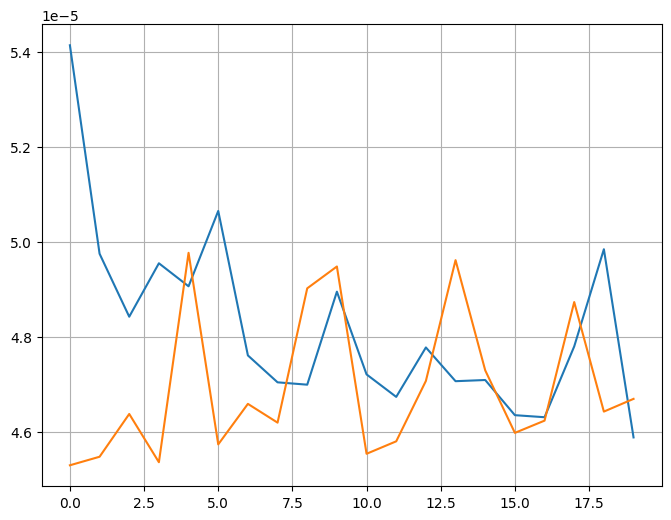

In [54]:
plt.plot(pd.DataFrame(history1.history))
plt.grid(True)
plt.gca()
plt.show()

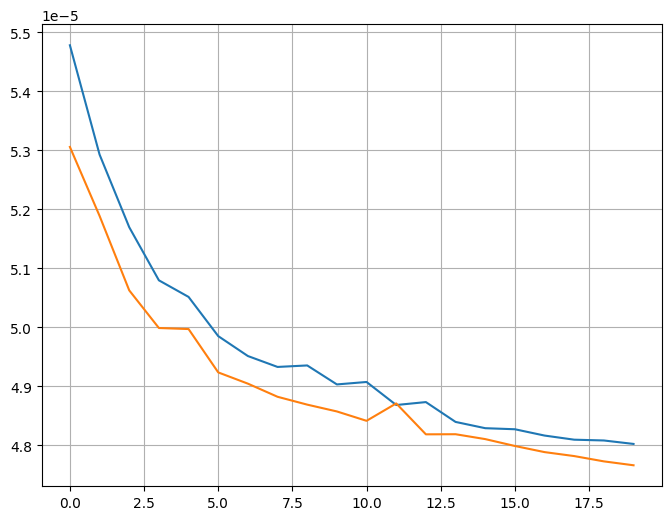

In [55]:
plt.plot(pd.DataFrame(history2.history))
plt.grid(True)
plt.gca()
plt.show()

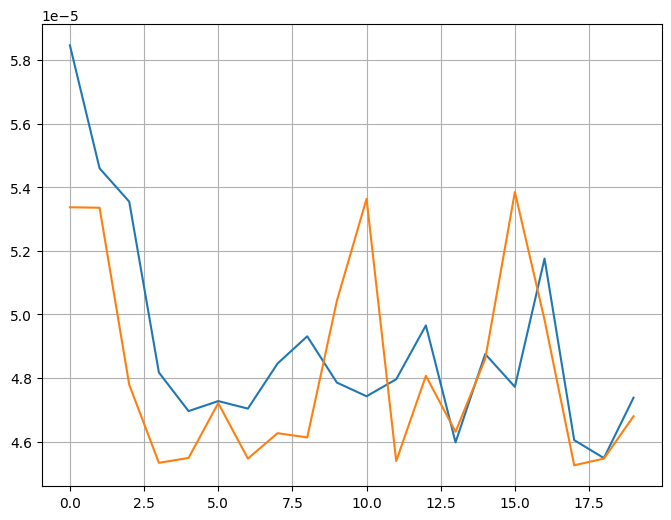

In [58]:
plt.plot(pd.DataFrame(history3.history))
plt.grid(True)
plt.gca()
plt.show()

In [59]:
print('The value of the last validation loss of Model 1: ', round(history1.history['val_loss'][-1], 7))
print('The value of the last validation loss of Model 2: ', round(history2.history['val_loss'][-1], 7))
print('The value of the last validation loss of Model 3: ', round(history3.history['val_loss'][-1], 7))

The value of the last validation loss of Model 1:  4.67e-05
The value of the last validation loss of Model 2:  4.77e-05
The value of the last validation loss of Model 3:  4.68e-05


### Using the model to make predictions

In [60]:
# Estimate accuracy on test set
predicted = model1.predict(X_test_LSTM)
print(mean_squared_error(Y_test,predicted))

7/7 [==============================] - 0s 4ms/step
4.6691448141239664e-05


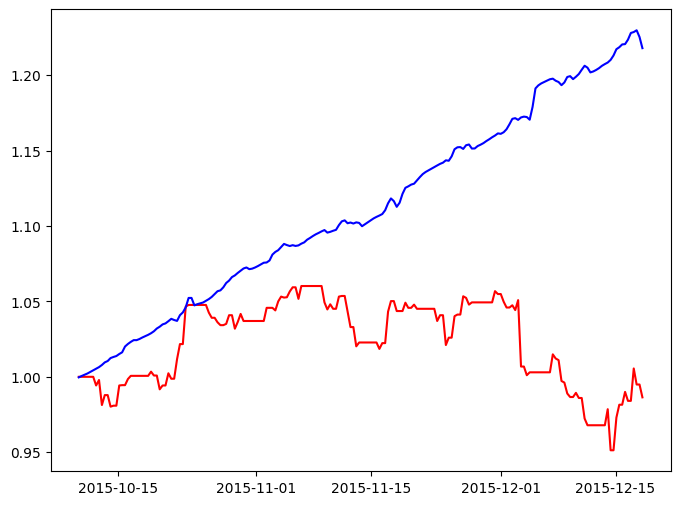

In [61]:
# Use the following code to produce the comparison of actual vs. predicted
predicted = pd.DataFrame(predicted)
predicted.index = Y_test.index
plt.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
plt.plot(np.exp(predicted).cumprod(), 'b')
plt.rcParams["figure.figsize"] = (8, 6)
plt.show()